In [1]:
from desc import set_device

set_device("gpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".93"

import numpy as np
import time

import desc
from desc.grid import LinearGrid, Grid
from desc.equilibrium import Equilibrium
from desc.optimize import Optimizer
from desc.plotting import *

from desc.objectives import (
    ForceBalance,
    ObjectiveFunction,
    QuasisymmetryTwoTerm,
    FixPsi,
    FixBoundaryR,
    FixBoundaryZ,
    GenericObjective,
    FixPressure,
    FixCurrent,
    FixIota,
    get_fixed_boundary_constraints,
    AspectRatio,
    EffectiveRipple,
    ObjectiveFunction,
)

from desc.plotting import *
from matplotlib import pyplot as plt
import numpy as np
import pdb

/home/rgaur/DESC/desc/__init__.py:98: UserWarning: No GPU found, falling back to CPU
  warnings.warn(colored("No GPU found, falling back to CPU", "yellow"))


DESC version 0.12.2+704.ge5127e031,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: CPU, with 14.57 GB available memory


# $\epsilon_{\mathrm{eff}}^{3/2}$ calculation for precise QH

In [2]:
# Importing the HELIOTRON DESC equilibrium
eq0 = desc.examples.get("precise_QH")

In [3]:
# Flux surfaces on which to evaluate ballooning stability
surfaces = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

# Field lines on which to evaluate ballooning stability
alpha = np.linspace(0, np.pi, 1, endpoint=False)

# Number of toroidal transits of the field line
ntransit = 3

knots_per_transit = 128

# Number of point along a field line in ballooning space
N0 = ntransit * knots_per_transit

# range of the ballooning coordinate zeta
zeta = np.linspace(-np.pi * ntransit, np.pi * ntransit, N0)

ripple_array_precise = np.zeros(len(surfaces))

for j in range(len(surfaces)):
    tic = time.time()
    rho = surfaces[j]

    grid = Grid.create_meshgrid(
        [rho, alpha, zeta], coordinates="raz", period=(np.inf, 2 * np.pi, np.inf)
    )

    ripple_array_precise[j] = np.squeeze(
        grid.compress(eq0.compute("effective ripple", grid=grid)["effective ripple"])
    )
    toc = time.time()
    print(f"surface {j} took {toc-tic:.2f} s")

print("Ripple calculation finished!")

surface 0 took 13.06 s
surface 1 took 2.25 s
surface 2 took 2.19 s
surface 3 took 2.22 s
surface 4 took 2.05 s
surface 5 took 2.07 s
surface 6 took 2.14 s
Ripple calculation finished!


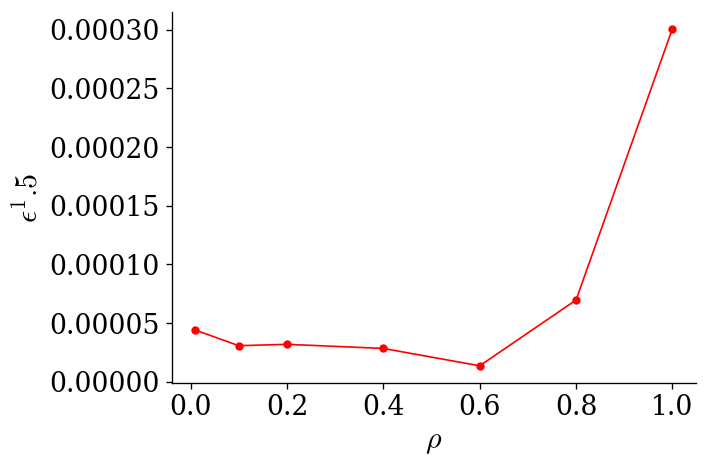

In [4]:
plt.plot(np.array(surfaces), ripple_array_precise, "-or", ms=4)
plt.xlabel(r"$\rho$", fontsize=18)
plt.ylabel(f"$\epsilon^{1.5}$", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

In [5]:
# Importing the HELIOTRON DESC equilibrium
eq0 = desc.examples.get("HELIOTRON")

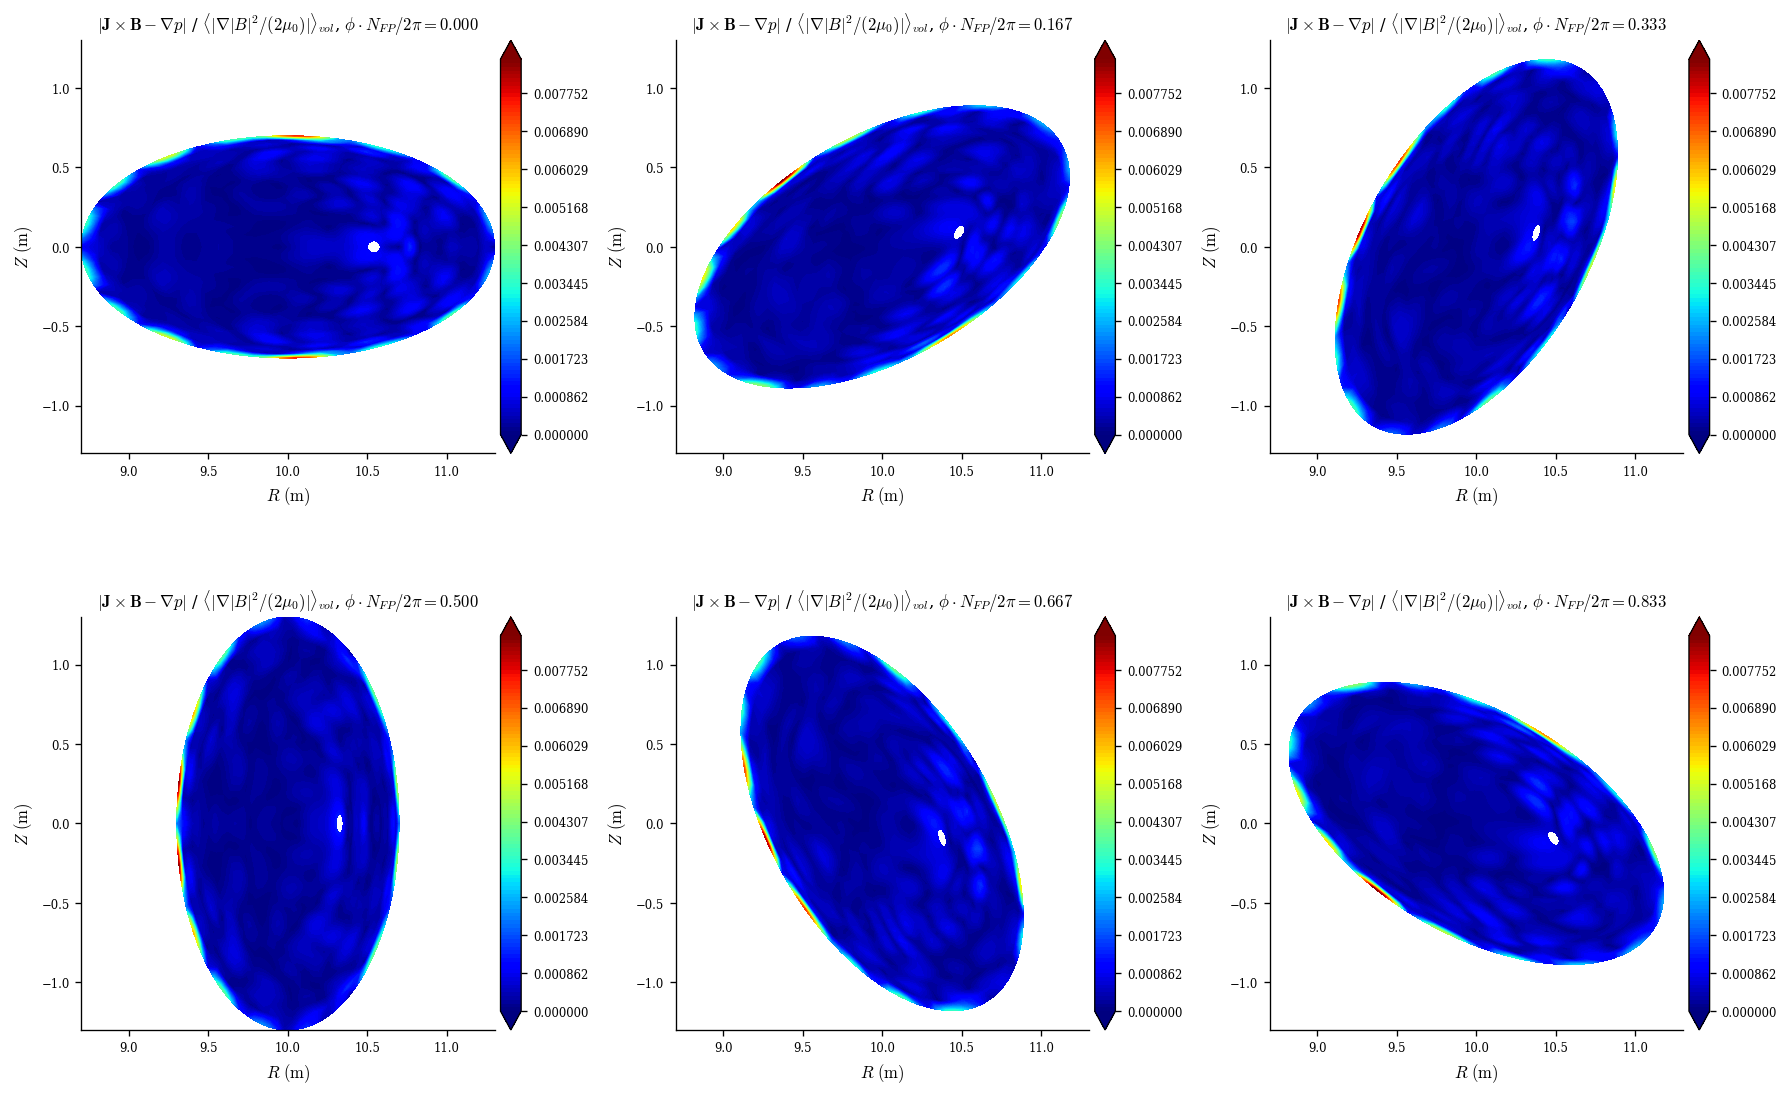

In [6]:
desc.plotting.plot_section(eq0, name="|F|", norm_F=True);

# $\epsilon_{\mathrm{eff}}^{3/2}$ calculation for an unoptimized equilibrium

In [7]:
# Flux surfaces on which to evaluate ballooning stability
surfaces = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

# Field lines on which to evaluate ballooning stability
alpha = np.linspace(0, np.pi, 1, endpoint=False)

# Number of toroidal transits of the field line
ntransit = 3

knots_per_transit = 128

# Number of point along a field line in ballooning space
N0 = ntransit * knots_per_transit

# range of the ballooning coordinate zeta
zeta = np.linspace(-np.pi * ntransit, np.pi * ntransit, N0)

ripple_array = np.zeros(len(surfaces))

for j in range(len(surfaces)):
    tic = time.time()
    rho = surfaces[j]

    grid = Grid.create_meshgrid(
        [rho, alpha, zeta], coordinates="raz", period=(np.inf, 2 * np.pi, np.inf)
    )

    ripple_array[j] = np.squeeze(
        grid.compress(eq0.compute("effective ripple", grid=grid)["effective ripple"])
    )
    toc = time.time()
    print(f"surface {j} took {toc-tic:.2f} s")

print("Ripple calculation finished!")

surface 0 took 7.28 s
surface 1 took 1.79 s
surface 2 took 1.83 s
surface 3 took 1.77 s
surface 4 took 1.76 s
surface 5 took 1.76 s
surface 6 took 1.81 s
Ripple calculation finished!


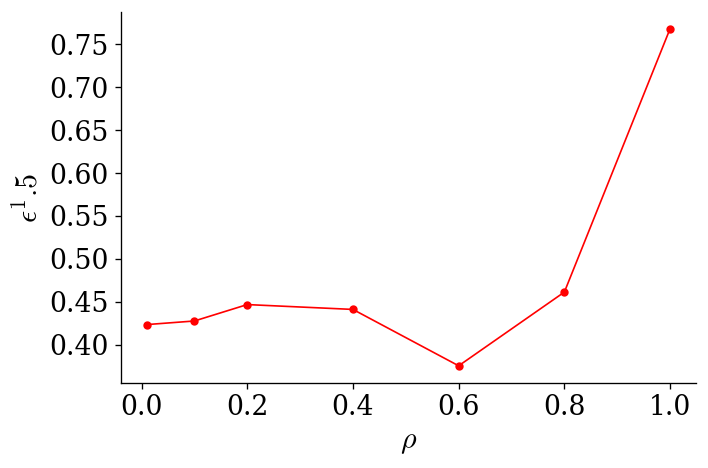

In [8]:
plt.plot(np.array(surfaces), ripple_array, "-or", ms=4)
plt.xlabel(r"$\rho$", fontsize=18)
plt.ylabel(f"$\epsilon^{1.5}$", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

# Reducing the Effective Ripple

In [9]:
# save a copy of original for comparison
eq1 = eq0.copy()

# Flux surfaces on which to evaluate ballooning stability
surfaces = [1.0]

nalpha = 1  # Number of field lines

# Field lines on which to evaluate ballooning stability
alpha = np.linspace(0, np.pi, nalpha, endpoint=False)

# Number of toroidal transits of the field line
num_transit = 3

# Number of point along a field line per transit
knots_per_transit = 64

# Determine which modes to unfix
k = 2

print("\n---------------------------------------")
print(f"Optimizing boundary modes M, N <= {k}")
print("---------------------------------------")

modes_R = np.vstack(
    (
        [0, 0, 0],
        eq1.surface.R_basis.modes[np.max(np.abs(eq1.surface.R_basis.modes), 1) > k, :],
    )
)
modes_Z = eq1.surface.Z_basis.modes[np.max(np.abs(eq1.surface.Z_basis.modes), 1) > k, :]
constraints = (
    ForceBalance(eq=eq1),
    FixBoundaryR(eq=eq1, modes=modes_R),
    FixBoundaryZ(eq=eq1, modes=modes_Z),
    FixPressure(eq=eq1),
    FixIota(eq=eq1),
    FixPsi(eq=eq1),
)

Curvature_grid = LinearGrid(
    M=2 * int(eq1.M),
    N=2 * int(eq1.N),
    rho=np.array([1.0]),
    NFP=eq1.NFP,
    sym=True,
    axis=False,
)

objective = ObjectiveFunction(
    (
        EffectiveRipple(
            eq=eq1,
            rho=np.array(surfaces),
            alpha=0,
            num_transit=num_transit,
            knots_per_transit=knots_per_transit,
            num_quad=17,
            weight=1e6,
            deriv_mode="rev",
        ),
        AspectRatio(
            eq=eq1,
            bounds=(8, 11),
            weight=1e3,
        ),
        GenericObjective(
            f="curvature_k2_rho",
            thing=eq1,
            grid=Curvature_grid,
            bounds=(-128, 10),
            weight=2e3,
        ),
    )
)


optimizer = Optimizer("proximal-lsq-exact")
(eq1,), _ = optimizer.optimize(
    eq1,
    objective,
    constraints,
    ftol=1e-4,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=5,  # increase maxiter to 50 for a better result
    verbose=3,
    options={"initial_trust_ratio": 2e-3},
)
print("Optimization complete!")


---------------------------------------
Optimizing boundary modes M, N <= 2
---------------------------------------
Building objective: Effective ripple
Precomputing transforms
Timer: Precomputing transforms = 57.7 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 59.1 ms
Building objective: generic
Timer: Objective build = 525 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 315 ms
Timer: Objective build = 836 ms
Timer: Proximal projection build = 7.00 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Timer: Objective build = 662 ms
Timer: Linear constraint projection build = 1.86 sec
Number of parameters: 24
Number of objectives: 327
Timer: Initializing the optimization = 9.59 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step

In [10]:
# Flux surfaces on which to evaluate ballooning stability
surfaces = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

# Field lines on which to evaluate ballooning stability
alpha = np.linspace(0, np.pi, 1, endpoint=False)

# Number of toroidal transits of the field line
ntransit = 6

knots_per_transit = 128

# Number of point along a field line in ballooning space
N0 = ntransit * knots_per_transit

# range of the ballooning coordinate zeta
zeta = np.linspace(-np.pi * ntransit, np.pi * ntransit, N0)

ripple_array_new = np.zeros(len(surfaces))

for j in range(len(surfaces)):
    tic = time.time()
    rho = surfaces[j]

    grid = Grid.create_meshgrid(
        [rho, alpha, zeta], coordinates="raz", period=(np.inf, 2 * np.pi, np.inf)
    )

    ripple_array_new[j] = np.squeeze(
        grid.compress(eq1.compute("effective ripple", grid=grid)["effective ripple"])
    )
    toc = time.time()
    print(f"surface {j} took {toc-tic:.2f} s")

print("Ripple calculation finished!")

surface 0 took 5.89 s
surface 1 took 2.21 s
surface 2 took 2.25 s
surface 3 took 2.31 s
surface 4 took 2.38 s
surface 5 took 2.22 s
surface 6 took 2.21 s
Ripple calculation finished!


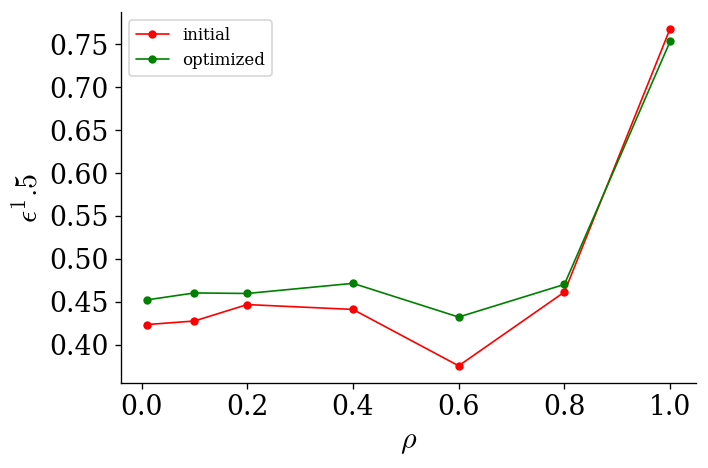

In [11]:
plt.plot(np.array(surfaces), ripple_array, "-or", ms=4)
plt.plot(np.array(surfaces), ripple_array_new, "-og", ms=4)
plt.xlabel(r"$\rho$", fontsize=18)
plt.ylabel(f"$\epsilon^{1.5}$", fontsize=18)
plt.legend(["initial", "optimized"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);